In [1]:
#Batch size 

Training samples: 1243
Validation samples: 163
Test samples: 294



/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40
----------
Train Loss: 0.4819 Acc: 0.7796
Val   Loss: 0.5970 Acc: 0.7055
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.2714 Acc: 0.9043
Val   Loss: 0.5849 Acc: 0.7117
✅ Best model saved!
Epoch 3/40
----------
Train Loss: 0.1657 Acc: 0.9493
Val   Loss: 0.5711 Acc: 0.7546
✅ Best model saved!
Epoch 4/40
----------
Train Loss: 0.1332 Acc: 0.9654
Val   Loss: 0.5376 Acc: 0.7730
✅ Best model saved!
Epoch 5/40
----------
Train Loss: 0.1177 Acc: 0.9726
Val   Loss: 0.5454 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 6/40
----------
Train Loss: 0.1175 Acc: 0.9670
Val   Loss: 0.5663 Acc: 0.7485
⏳ No improvement for 2 epochs.
Epoch 7/40
----------
Train Loss: 0.0780 Acc: 0.9799
Val   Loss: 0.6082 Acc: 0.7730
⏳ No improvement for 3 epochs.
Epoch 8/40
----------
Train Loss: 0.0666 Acc: 0.9855
Val   Loss: 0.5435 Acc: 0.7853
✅ Best model saved!
Epoch 9/40
----------
Train Loss: 0.1027 Acc: 0.9710
Val   Loss: 0.5522 Acc: 0.7607
⏳ No improvement for 1 epochs.
Epoch 10/40
--------

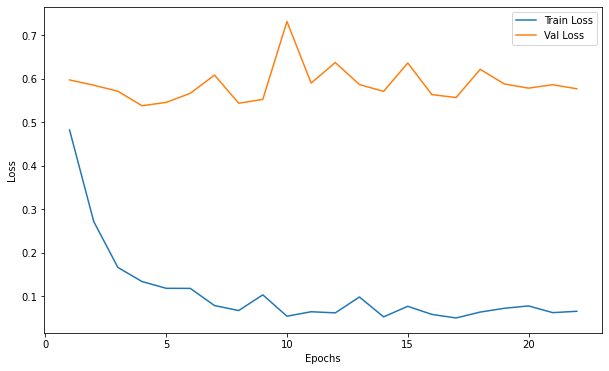

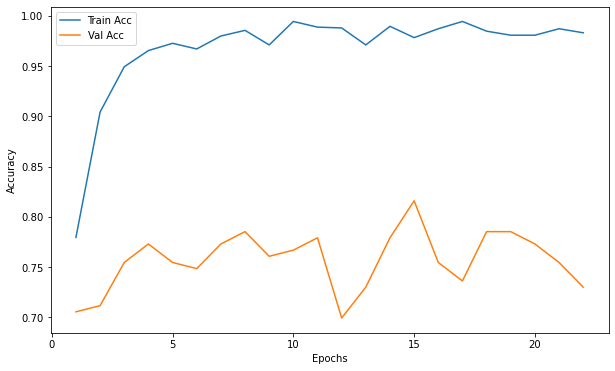

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)
        
        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_model(device):
    model = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

    # Freeze the stem (first few layers) to prevent overfitting
    for param in model.stem.parameters():
        param.requires_grad = False

    # Add Batch Normalization after the convolution layers to stabilize training
    model.stem.add_module('batch_norm', nn.BatchNorm3d(64))

    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)  # Ensure the output is of shape [batch_size, 1]
    )

    model = model.to(device)
    return model

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=7):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler (adjust learning rate when validation loss plateaus)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5  # Threshold for binary classification

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))
    
    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)  # Specificity formula
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)import os
import shutil
from sklearn.model_selection import train_test_split

# Directory paths for processed control and processed parkinson data
control_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_control"
parkinson_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_parkinson"

# Create res_split folder structure
res_split_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"
os.makedirs(os.path.join(res_split_dir, 'train', 'control'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'val', 'control'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'test', 'control'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'train', 'parkinson'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'val', 'parkinson'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'test', 'parkinson'), exist_ok=True)

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split('_')[0]

# Function to create splits
def create_patient_split(data_dir, split_dir, category):
    files = os.listdir(data_dir)
    patient_ids = set([extract_patient_id(f) for f in files])

    # Split patient IDs (70% for train, 10% for val, 20% for test)
    train_patient_ids, temp_patient_ids = train_test_split(list(patient_ids), test_size=0.3, shuffle=False)
    val_patient_ids, test_patient_ids = train_test_split(temp_patient_ids, test_size=2/3, shuffle=False)

    # Function to copy files based on patient ID
    def copy_files(patient_ids, source_dir, target_dir):
        for patient_id in patient_ids:
            patient_files = [f for f in os.listdir(source_dir) if extract_patient_id(f) == patient_id]
            for file in patient_files:
                shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))

    # Copy files to the respective split folders
    copy_files(train_patient_ids, data_dir, os.path.join(split_dir, 'train', category))
    copy_files(val_patient_ids, data_dir, os.path.join(split_dir, 'val', category))
    copy_files(test_patient_ids, data_dir, os.path.join(split_dir, 'test', category))

# Create splits for control and parkinson data
create_patient_split(control_dir, res_split_dir, 'control')
create_patient_split(parkinson_dir, res_split_dir, 'parkinson')

# Display quantities in each split
print(f"Train Control: {len(os.listdir(os.path.join(res_split_dir, 'train', 'control')))} files")
print(f"Val Control: {len(os.listdir(os.path.join(res_split_dir, 'val', 'control')))} files")
print(f"Test Control: {len(os.listdir(os.path.join(res_split_dir, 'test', 'control')))} files")
print(f"Train Parkinson: {len(os.listdir(os.path.join(res_split_dir, 'train', 'parkinson')))} files")
print(f"Val Parkinson: {len(os.listdir(os.path.join(res_split_dir, 'val', 'parkinson')))} files")
print(f"Test Parkinson: {len(os.listdir(os.path.join(res_split_dir, 'test', 'parkinson')))} files")


    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")
    
    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")
    
    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Dataset
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_model(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # Train the model
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set
    test_labels, test_preds = evaluate_model(model, test_loader, device)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directory paths for processed control and processed parkinson data
control_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_control"
parkinson_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_parkinson1"

# Create res_split folder structure
res_split_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split_t1"
os.makedirs(os.path.join(res_split_dir, 'train', 'control'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'val', 'control'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'test', 'control'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'train', 'parkinson'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'val', 'parkinson'), exist_ok=True)
os.makedirs(os.path.join(res_split_dir, 'test', 'parkinson'), exist_ok=True)

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split('_')[0]

# Function to create splits
def create_patient_split(data_dir, split_dir, category):
    files = os.listdir(data_dir)
    patient_ids = set([extract_patient_id(f) for f in files])

    # Split patient IDs (70% for train, 10% for val, 20% for test)
    train_patient_ids, temp_patient_ids = train_test_split(list(patient_ids), test_size=0.3, shuffle=False)
    val_patient_ids, test_patient_ids = train_test_split(temp_patient_ids, test_size=2/3, shuffle=False)

    # Function to copy files based on patient ID
    def copy_files(patient_ids, source_dir, target_dir):
        for patient_id in patient_ids:
            patient_files = [f for f in os.listdir(source_dir) if extract_patient_id(f) == patient_id]
            for file in patient_files:
                shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))

    # Copy files to the respective split folders
    copy_files(train_patient_ids, data_dir, os.path.join(split_dir, 'train', category))
    copy_files(val_patient_ids, data_dir, os.path.join(split_dir, 'val', category))
    copy_files(test_patient_ids, data_dir, os.path.join(split_dir, 'test', category))

# Create splits for control and parkinson data
create_patient_split(control_dir, res_split_dir, 'control')
create_patient_split(parkinson_dir, res_split_dir, 'parkinson')

# Display quantities in each split
print(f"Train Control: {len(os.listdir(os.path.join(res_split_dir, 'train', 'control')))} files")
print(f"Val Control: {len(os.listdir(os.path.join(res_split_dir, 'val', 'control')))} files")
print(f"Test Control: {len(os.listdir(os.path.join(res_split_dir, 'test', 'control')))} files")
print(f"Train Parkinson: {len(os.listdir(os.path.join(res_split_dir, 'train', 'parkinson')))} files")
print(f"Val Parkinson: {len(os.listdir(os.path.join(res_split_dir, 'val', 'parkinson')))} files")
print(f"Test Parkinson: {len(os.listdir(os.path.join(res_split_dir, 'test', 'parkinson')))} files")


Train Control: 216 files
Val Control: 30 files
Test Control: 75 files
Train Parkinson: 299 files
Val Parkinson: 45 files
Test Parkinson: 90 files


Training samples: 515
Validation samples: 75
Test samples: 165

Epoch 1/40
----------
Train Loss: 0.3953 Acc: 0.8039
Val   Loss: 5.0690 Acc: 0.4000
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.1642 Acc: 0.9320
Val   Loss: 1.8099 Acc: 0.6000
✅ Best model saved!
Epoch 3/40
----------
Train Loss: 0.0477 Acc: 0.9806
Val   Loss: 0.7245 Acc: 0.7467
✅ Best model saved!
Epoch 4/40
----------
Train Loss: 0.0549 Acc: 0.9786
Val   Loss: 2.8397 Acc: 0.4267
⏳ No improvement for 1 epoch(s).
Epoch 5/40
----------
Train Loss: 0.0620 Acc: 0.9806
Val   Loss: 1.7329 Acc: 0.4267
⏳ No improvement for 2 epoch(s).
Epoch 6/40
----------
Train Loss: 0.0385 Acc: 0.9864
Val   Loss: 1.2291 Acc: 0.6667
⏳ No improvement for 3 epoch(s).
Epoch 7/40
----------
Train Loss: 0.0223 Acc: 0.9922
Val   Loss: 0.8474 Acc: 0.6533
⏳ No improvement for 4 epoch(s).
Epoch 8/40
----------
Train Loss: 0.0137 Acc: 0.9961
Val   Loss: 0.6280 Acc: 0.8133
✅ Best model saved!
Epoch 9/40
----------
Train Loss: 0.0065 Acc: 1.0000

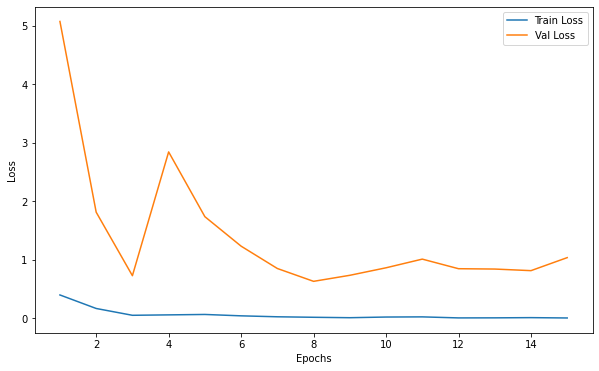

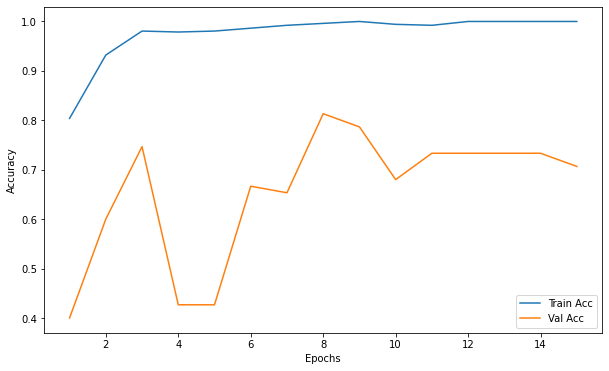

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)
        
        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_model(device):
    model = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

    # Freeze the stem (first few layers) to prevent overfitting
    for param in model.stem.parameters():
        param.requires_grad = False

    # Add Batch Normalization after the convolution layers to stabilize training
    model.stem.add_module('batch_norm', nn.BatchNorm3d(64))

    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)  # Ensure the output is of shape [batch_size, 1]
    )

    model = model.to(device)
    return model

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=7):
    best_loss = float('inf')  # Initialize best_loss to infinity
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler (adjust learning rate when validation loss plateaus)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epoch(s).")

        # Early Stopping
        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    print("\nTraining complete")
    print(f"Best Validation Loss: {best_loss:.4f}")

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history


def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5  # Threshold for binary classification

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))
    
    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)  # Specificity formula
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split_t1"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")
    
    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")
    
    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Dataset
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    batch_size = 12
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_model(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-4)

    # Train the model
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set
    test_labels, test_preds = evaluate_model(model, test_loader, device)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()


Training samples: 1243
Validation samples: 163
Test samples: 294



/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40
----------
Train Loss: 0.3483 Acc: 0.8842
Val   Loss: 0.5141 Acc: 0.8037
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.1301 Acc: 0.9614
Val   Loss: 0.8006 Acc: 0.7791
⏳ No improvement for 1 epochs.
Epoch 3/40
----------
Train Loss: 0.0762 Acc: 0.9791
Val   Loss: 0.8252 Acc: 0.7669
⏳ No improvement for 2 epochs.
Epoch 4/40
----------
Train Loss: 0.0976 Acc: 0.9743
Val   Loss: 0.9691 Acc: 0.7485
⏳ No improvement for 3 epochs.
Epoch 5/40
----------
Train Loss: 0.0566 Acc: 0.9831
Val   Loss: 0.9168 Acc: 0.7546
⏳ No improvement for 4 epochs.
Epoch 6/40
----------
Train Loss: 0.0219 Acc: 0.9952
Val   Loss: 1.0554 Acc: 0.7546
⏳ No improvement for 5 epochs.
Epoch 7/40
----------
Train Loss: 0.0266 Acc: 0.9960
Val   Loss: 0.8031 Acc: 0.8098
✅ Best model saved!
Epoch 8/40
----------
Train Loss: 0.0272 Acc: 0.9944
Val   Loss: 0.7674 Acc: 0.8037
⏳ No improvement for 1 epochs.
Epoch 9/40
----------
Train Loss: 0.0194 Acc: 0.9952
Val   Loss: 0.9355 Acc: 0.7853
⏳ No improvement f

/home/pfc5346/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pfc5346/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pfc5346/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


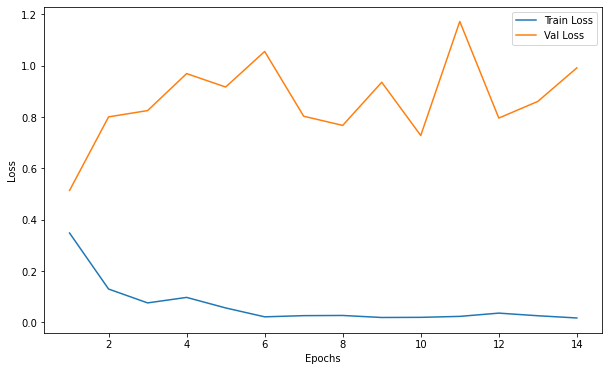

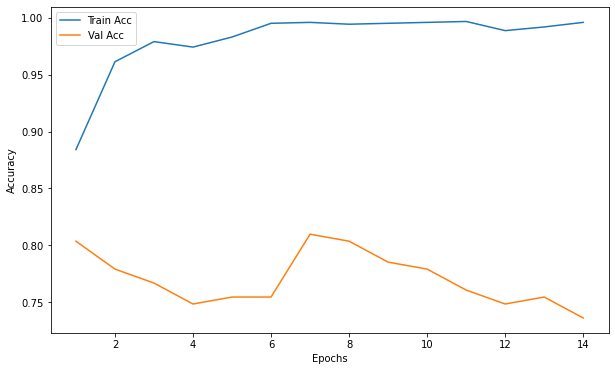

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_class_weights(labels):
    class_sample_count = np.array(
        [len(np.where(labels == t)[0]) for t in np.unique(labels)]
    )
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in labels])
    return samples_weight

def get_model(device):
    model = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7),
                              stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

    # Unfreeze some layers to allow the model to learn more features
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Add Batch Normalization after the convolution layers to stabilize training
    model.stem.add_module('batch_norm', nn.BatchNorm3d(64))

    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)  # Ensure the output is of shape [batch_size, 1]
    )

    model = model.to(device)
    return model

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=7):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler (adjust learning rate when validation loss plateaus)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5  # Threshold for binary classification

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Dataset
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    batch_size = 8

    # Calculate weights for the training samples
    train_labels = np.array(train_dataset.labels)
    samples_weight = get_class_weights(train_labels)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_model(device)

    # Calculate class weights for the loss function
    class_counts = np.bincount(train_labels)
    class_weights = [sum(class_counts) / c for c in class_counts]
    class_weights = torch.tensor(class_weights).float().to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

    # Train the model
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set
    test_labels, test_preds = evaluate_model(model, test_loader, device)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()


Training samples: 1243
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 442, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}

Epoch 1/40
----------


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.0796 Acc: 0.6243
Val   Loss: 0.0773 Acc: 0.7791
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.0616 Acc: 0.7249
Val   Loss: 0.0692 Acc: 0.7730
⏳ No improvement for 1 epochs.
Epoch 3/40
----------
Train Loss: 0.0582 Acc: 0.7691
Val   Loss: 0.0560 Acc: 0.7546
⏳ No improvement for 2 epochs.
Epoch 4/40
----------
Train Loss: 0.0456 Acc: 0.8367
Val   Loss: 0.0649 Acc: 0.8037
✅ Best model saved!
Epoch 5/40
----------
Train Loss: 0.0442 Acc: 0.7699
Val   Loss: 0.0591 Acc: 0.7730
⏳ No improvement for 1 epochs.
Epoch 6/40
----------
Train Loss: 0.0472 Acc: 0.7289
Val   Loss: 0.0943 Acc: 0.7546
⏳ No improvement for 2 epochs.
Epoch 7/40
----------
Train Loss: 0.0380 Acc: 0.7707
Val   Loss: 0.0630 Acc: 0.7423
⏳ No improvement for 3 epochs.
Epoch 8/40
----------
Train Loss: 0.0375 Acc: 0.7474
Val   Loss: 0.0604 Acc: 0.7914
⏳ No improvement for 4 epochs.
Epoch 9/40
----------
Train Loss: 0.0362 Acc: 0.7892
Val   Loss: 0.0680 Acc: 0.8160
✅ Best model saved!
Epoch 10/40
--------

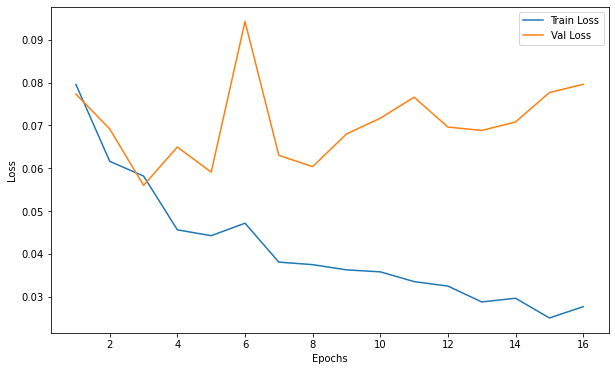

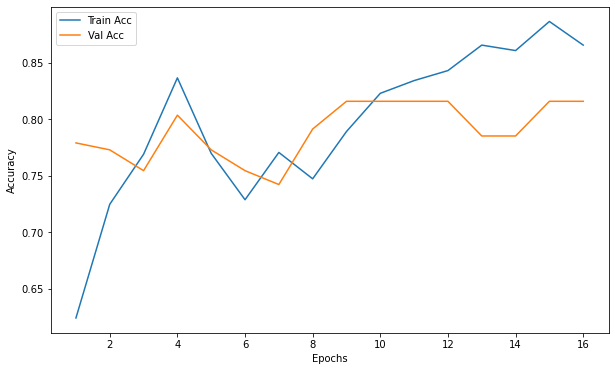

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

def get_sample_weights(labels):
    class_sample_count = np.bincount(labels)
    weights = 1. / class_sample_count
    samples_weight = weights[labels]
    return samples_weight

def get_simple_model(device):
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=20):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(dim=-1)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    preds = (all_probs > threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Dataset
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Calculate weights for the training samples
    train_labels = np.array(train_dataset.labels)
    samples_weight = get_sample_weights(train_labels)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_simple_model(device)

    # Use Focal Loss
    criterion = FocalLoss(alpha=0.5, gamma=2)

    # Adjust optimizer and learning rate
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

    # Train the model
    model, history, best_threshold = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set using the best threshold
    test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device, threshold=best_threshold)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()


Training samples: 1243
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 442, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}

Epoch 1/40
----------


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.0870 Acc: 0.6267
Val   Loss: 0.0713 Acc: 0.7730
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.0625 Acc: 0.7490
Val   Loss: 0.0648 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 3/40
----------
Train Loss: 0.0648 Acc: 0.6935
Val   Loss: 0.0655 Acc: 0.8160
✅ Best model saved!
Epoch 4/40
----------
Train Loss: 0.0616 Acc: 0.6959
Val   Loss: 0.0654 Acc: 0.8160
⏳ No improvement for 1 epochs.
Epoch 5/40
----------
Train Loss: 0.0608 Acc: 0.6903
Val   Loss: 0.0624 Acc: 0.8098
⏳ No improvement for 2 epochs.
Epoch 6/40
----------
Train Loss: 0.0539 Acc: 0.7353
Val   Loss: 0.0569 Acc: 0.8160
⏳ No improvement for 3 epochs.
Epoch 7/40
----------
Train Loss: 0.0541 Acc: 0.7257
Val   Loss: 0.0558 Acc: 0.8589
✅ Best model saved!
Epoch 8/40
----------
Train Loss: 0.0488 Acc: 0.7570
Val   Loss: 0.0642 Acc: 0.8160
⏳ No improvement for 1 epochs.
Epoch 9/40
----------
Train Loss: 0.0461 Acc: 0.7458
Val   Loss: 0.0592 Acc: 0.8282
⏳ No improvement for 2 epochs.
Epoch 10/40
--------

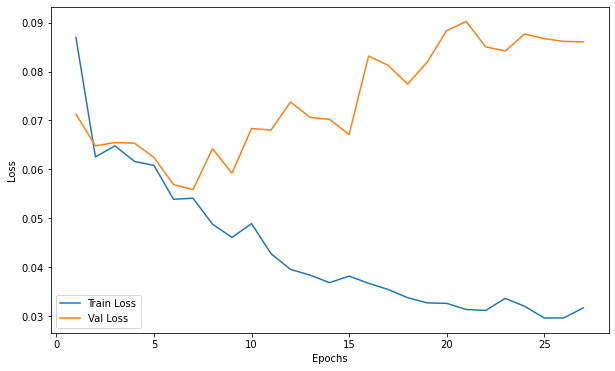

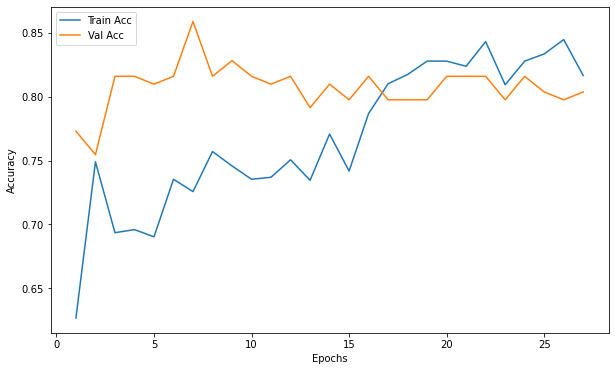

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

def get_sample_weights(labels):
    class_sample_count = np.bincount(labels)
    weights = 1. / class_sample_count
    samples_weight = weights[labels]
    return samples_weight

def get_simple_model(device):
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=20):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(dim=-1)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    preds = (all_probs > threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Dataset
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Calculate weights for the training samples
    train_labels = np.array(train_dataset.labels)
    samples_weight = get_sample_weights(train_labels)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_simple_model(device)

    # Use Focal Loss
    criterion = FocalLoss(alpha=0.5, gamma=2)

    # Adjust optimizer and learning rate
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

    # Train the model
    model, history, best_threshold = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set using the best threshold
    test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device, threshold=best_threshold)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()


Training samples: 1602
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 801, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}

Epoch 1/40
----------


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.2558 Acc: 0.6055
Val   Loss: 0.2687 Acc: 0.5460
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.2427 Acc: 0.5512
Val   Loss: 0.2336 Acc: 0.7546
✅ Best model saved!
Epoch 3/40
----------
Train Loss: 0.2535 Acc: 0.5106
Val   Loss: 0.2614 Acc: 0.2454
⏳ No improvement for 1 epochs.
Epoch 4/40
----------
Train Loss: 0.2463 Acc: 0.5387
Val   Loss: 0.2635 Acc: 0.6933
⏳ No improvement for 2 epochs.
Epoch 5/40
----------
Train Loss: 0.2482 Acc: 0.5506
Val   Loss: 0.2529 Acc: 0.7546
⏳ No improvement for 3 epochs.
Epoch 6/40
----------
Train Loss: 0.2602 Acc: 0.5000
Val   Loss: 0.2544 Acc: 0.7546
⏳ No improvement for 4 epochs.
Epoch 7/40
----------
Train Loss: 0.2601 Acc: 0.5000
Val   Loss: 0.2559 Acc: 0.7546
⏳ No improvement for 5 epochs.
Epoch 8/40
----------
Train Loss: 0.2600 Acc: 0.5000
Val   Loss: 0.2570 Acc: 0.7546
⏳ No improvement for 6 epochs.
Epoch 9/40
----------
Train Loss: 0.2600 Acc: 0.5000
Val   Loss: 0.2574 Acc: 0.7546
⏳ No improvement for 7 epochs.
Epoch 10/

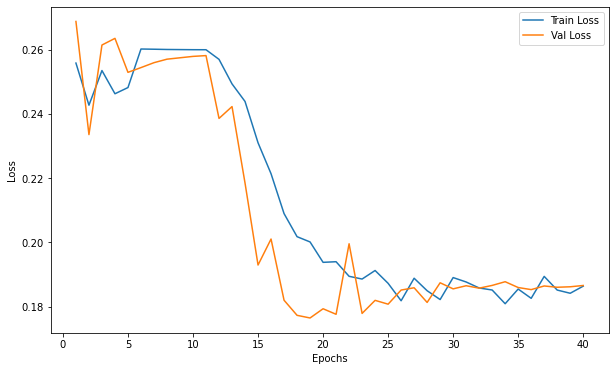

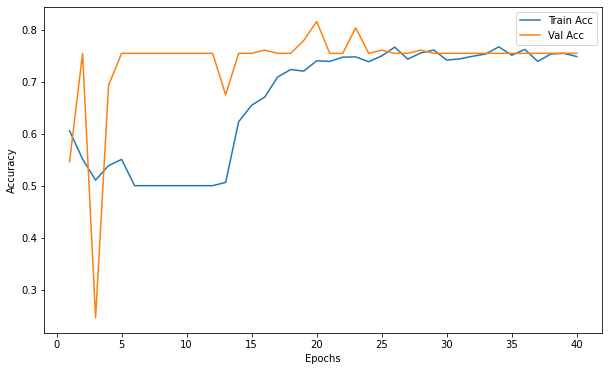

In [13]:
import os
import random  # Import random module
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class OversampledMRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats,
    with oversampling of the minority class (Healthy controls).
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        control_file_paths = []
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                control_file_paths.append(os.path.join(control_dir, filename))
        control_labels = [0] * len(control_file_paths)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        parkinson_file_paths = []
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                parkinson_file_paths.append(os.path.join(parkinson_dir, filename))
        parkinson_labels = [1] * len(parkinson_file_paths)  # Label for Parkinson's patients

        # Oversample control samples to match the number of Parkinson's samples
        num_control = len(control_file_paths)
        num_parkinson = len(parkinson_file_paths)
        if num_control < num_parkinson:
            # Calculate how many times to duplicate the control samples
            num_duplicates = num_parkinson // num_control
            remainder = num_parkinson % num_control

            # Duplicate control samples
            oversampled_control_file_paths = control_file_paths * num_duplicates
            oversampled_control_labels = control_labels * num_duplicates

            # Add additional samples to match exactly
            if remainder > 0:
                oversampled_control_file_paths += control_file_paths[:remainder]
                oversampled_control_labels += control_labels[:remainder]
        else:
            # No need to oversample
            oversampled_control_file_paths = control_file_paths
            oversampled_control_labels = control_labels

        # Combine the oversampled control samples with the Parkinson's samples
        self.file_paths = oversampled_control_file_paths + parkinson_file_paths
        self.labels = oversampled_control_labels + parkinson_labels

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

def get_simple_model(device):
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=20):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(dim=-1)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    preds = (all_probs > threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Use OversampledMRIDataset for training
    train_dataset = OversampledMRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_simple_model(device)

    # Use Focal Loss with adjusted parameters
    criterion = FocalLoss(alpha=0.75, gamma=1.0)

    # Adjust optimizer and learning rate
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

    # Train the model
    model, history, best_threshold = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set using the best threshold
    test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device, threshold=best_threshold)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()

Training samples: 1602
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 801, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}

Epoch 1/40
----------


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.2269 Acc: 0.6654
Val   Loss: 0.2419 Acc: 0.7117
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.1734 Acc: 0.7772
Val   Loss: 0.2005 Acc: 0.7546
✅ Best model saved!
Epoch 3/40
----------
Train Loss: 0.1534 Acc: 0.8021
Val   Loss: 0.2566 Acc: 0.5890
⏳ No improvement for 1 epochs.
Epoch 4/40
----------
Train Loss: 0.1110 Acc: 0.8770
Val   Loss: 0.1742 Acc: 0.8037
✅ Best model saved!
Epoch 5/40
----------
Train Loss: 0.0882 Acc: 0.9145
Val   Loss: 0.1987 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 6/40
----------
Train Loss: 0.0673 Acc: 0.9444
Val   Loss: 0.1617 Acc: 0.8344
✅ Best model saved!
Epoch 7/40
----------
Train Loss: 0.0530 Acc: 0.9613
Val   Loss: 0.1870 Acc: 0.8160
⏳ No improvement for 1 epochs.
Epoch 8/40
----------
Train Loss: 0.0417 Acc: 0.9719
Val   Loss: 0.1920 Acc: 0.8160
⏳ No improvement for 2 epochs.
Epoch 9/40
----------
Train Loss: 0.0378 Acc: 0.9750
Val   Loss: 0.2293 Acc: 0.8160
⏳ No improvement for 3 epochs.
Epoch 10/40
----------
Train Lo

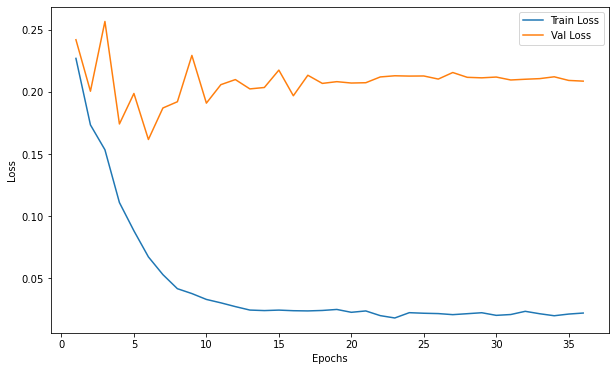

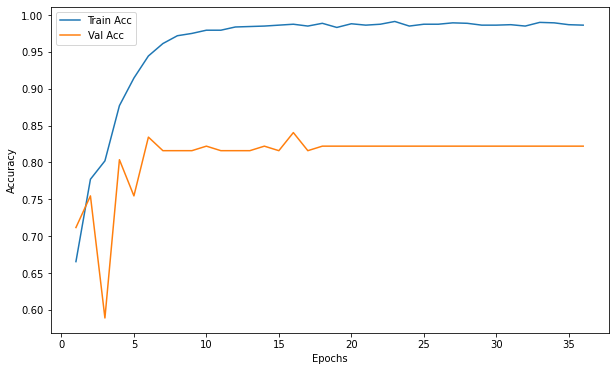

In [14]:
import os
import random  # Import random module
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class OversampledMRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats,
    with oversampling of the minority class (Healthy controls).
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        control_file_paths = []
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                control_file_paths.append(os.path.join(control_dir, filename))
        control_labels = [0] * len(control_file_paths)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        parkinson_file_paths = []
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                parkinson_file_paths.append(os.path.join(parkinson_dir, filename))
        parkinson_labels = [1] * len(parkinson_file_paths)  # Label for Parkinson's patients

        # Oversample control samples to match the number of Parkinson's samples
        num_control = len(control_file_paths)
        num_parkinson = len(parkinson_file_paths)
        if num_control < num_parkinson:
            # Calculate how many times to duplicate the control samples
            num_duplicates = num_parkinson // num_control
            remainder = num_parkinson % num_control

            # Duplicate control samples
            oversampled_control_file_paths = control_file_paths * num_duplicates
            oversampled_control_labels = control_labels * num_duplicates

            # Add additional samples to match exactly
            if remainder > 0:
                oversampled_control_file_paths += control_file_paths[:remainder]
                oversampled_control_labels += control_labels[:remainder]
        else:
            # No need to oversample
            oversampled_control_file_paths = control_file_paths
            oversampled_control_labels = control_labels

        # Combine the oversampled control samples with the Parkinson's samples
        self.file_paths = oversampled_control_file_paths + parkinson_file_paths
        self.labels = oversampled_control_labels + parkinson_labels

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

def get_simple_model(device):
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=20):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(dim=-1)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    preds = (all_probs > threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Use OversampledMRIDataset for training
    train_dataset = OversampledMRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_simple_model(device)

    # Use Focal Loss with adjusted parameters
    criterion = FocalLoss(alpha=0.75, gamma=1.0)

    # Adjust optimizer and learning rate
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5)

    # Train the model
    model, history, best_threshold = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set using the best threshold
    test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device, threshold=best_threshold)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()

Training samples: 1602
Validation samples: 246
Test samples: 468

Epoch 1/40
----------
Train Loss: 0.4605 Acc: 0.7740
Val   Loss: 0.8676 Acc: 0.6179
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.1711 Acc: 0.9582
Val   Loss: 1.1716 Acc: 0.5854
⏳ No improvement for 1 epochs.
Epoch 3/40
----------
Train Loss: 0.0881 Acc: 0.9794
Val   Loss: 1.4755 Acc: 0.6016
⏳ No improvement for 2 epochs.
Epoch 4/40
----------
Train Loss: 0.0522 Acc: 0.9888
Val   Loss: 0.9654 Acc: 0.5854
⏳ No improvement for 3 epochs.
Epoch 5/40
----------
Train Loss: 0.0319 Acc: 0.9944
Val   Loss: 1.2936 Acc: 0.5407
⏳ No improvement for 4 epochs.
Epoch 6/40
----------
Train Loss: 0.0464 Acc: 0.9869
Val   Loss: 1.2828 Acc: 0.5528
⏳ No improvement for 5 epochs.
Epoch 7/40
----------
Train Loss: 0.0377 Acc: 0.9938
Val   Loss: 1.6861 Acc: 0.5854
⏳ No improvement for 6 epochs.
Epoch 8/40
----------
Train Loss: 0.0240 Acc: 0.9975
Val   Loss: 1.2853 Acc: 0.5569
⏳ No improvement for 7 epochs.
🛑 Early stopping triggere

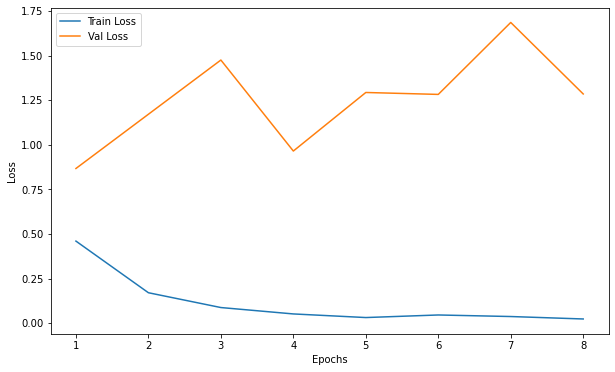

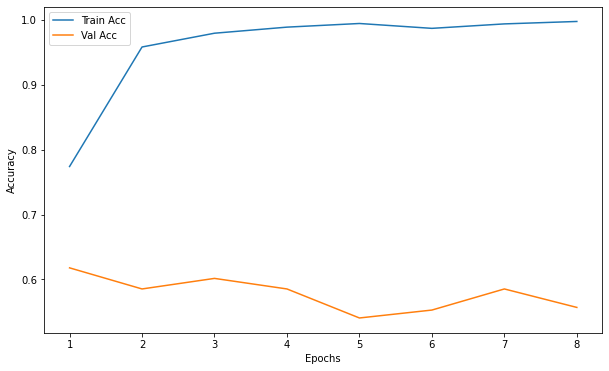

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import random  # Add this import

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        control_file_paths = []
        control_labels = []

        parkinson_file_paths = []
        parkinson_labels = []

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                control_file_paths.append(os.path.join(control_dir, filename))
                control_labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                parkinson_file_paths.append(os.path.join(parkinson_dir, filename))
                parkinson_labels.append(1)  # Label for Parkinson's patients

        # Now upsample the minority class
        control_count = len(control_labels)
        parkinson_count = len(parkinson_labels)

        if control_count > parkinson_count:
            # Upsample Parkinson's samples
            upsample_factor = control_count // parkinson_count
            remainder = control_count % parkinson_count

            parkinson_file_paths_upsampled = parkinson_file_paths * upsample_factor + parkinson_file_paths[:remainder]
            parkinson_labels_upsampled = parkinson_labels * upsample_factor + parkinson_labels[:remainder]

            control_file_paths_upsampled = control_file_paths
            control_labels_upsampled = control_labels

        elif parkinson_count > control_count:
            # Upsample control samples
            upsample_factor = parkinson_count // control_count
            remainder = parkinson_count % control_count

            control_file_paths_upsampled = control_file_paths * upsample_factor + control_file_paths[:remainder]
            control_labels_upsampled = control_labels * upsample_factor + control_labels[:remainder]

            parkinson_file_paths_upsampled = parkinson_file_paths
            parkinson_labels_upsampled = parkinson_labels
        else:
            # Classes are balanced
            control_file_paths_upsampled = control_file_paths
            control_labels_upsampled = control_labels
            parkinson_file_paths_upsampled = parkinson_file_paths
            parkinson_labels_upsampled = parkinson_labels

        # Combine the upsampled lists
        self.file_paths = control_file_paths_upsampled + parkinson_file_paths_upsampled
        self.labels = control_labels_upsampled + parkinson_labels_upsampled

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)
        
        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label
def get_model(device):
    model = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

    # Freeze the stem (first few layers) to prevent overfitting
    for param in model.stem.parameters():
        param.requires_grad = False

    # Add Batch Normalization after the convolution layers to stabilize training
    model.stem.add_module('batch_norm', nn.BatchNorm3d(64))

    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)  # Ensure the output is of shape [batch_size, 1]
    )

    model = model.to(device)
    return model

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=7):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler (adjust learning rate when validation loss plateaus)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5  # Threshold for binary classification

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))
    
    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)  # Specificity formula
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")
    
    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")
    
    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Dataset
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_model(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # Train the model
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set
    test_labels, test_preds = evaluate_model(model, test_loader, device)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()


Training samples: 1243
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 442, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}

Epoch 1/100
----------


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.0910 Acc: 0.6026
Val   Loss: 0.0780 Acc: 0.7485
✅ Best model saved!
Epoch 2/100
----------
Train Loss: 0.0746 Acc: 0.6669
Val   Loss: 0.0661 Acc: 0.7546
✅ Best model saved!
Epoch 3/100
----------
Train Loss: 0.0748 Acc: 0.6854
Val   Loss: 0.0831 Acc: 0.5767
⏳ No improvement for 1 epochs.
Epoch 4/100
----------
Train Loss: 0.0706 Acc: 0.6967
Val   Loss: 0.0598 Acc: 0.7546
⏳ No improvement for 2 epochs.
Epoch 5/100
----------
Train Loss: 0.0733 Acc: 0.6516
Val   Loss: 0.0977 Acc: 0.2454
⏳ No improvement for 3 epochs.
Epoch 6/100
----------
Train Loss: 0.0872 Acc: 0.5036
Val   Loss: 0.0949 Acc: 0.2454
⏳ No improvement for 4 epochs.
Epoch 7/100
----------
Train Loss: 0.0802 Acc: 0.5012
Val   Loss: 0.0908 Acc: 0.2454
⏳ No improvement for 5 epochs.
Epoch 8/100
----------
Train Loss: 0.0768 Acc: 0.5334
Val   Loss: 0.0953 Acc: 0.2454
⏳ No improvement for 6 epochs.
Epoch 9/100
----------
Train Loss: 0.0761 Acc: 0.5181
Val   Loss: 0.0881 Acc: 0.2454
⏳ No improvement for 7 epochs.
E

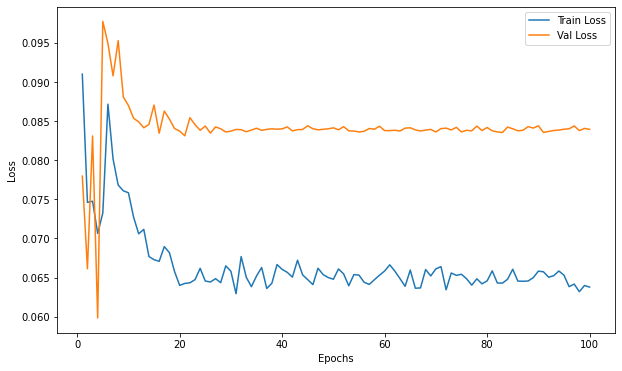

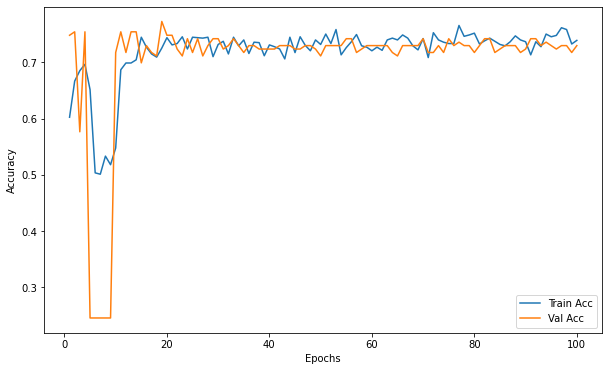

In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

def get_sample_weights(labels):
    class_sample_count = np.bincount(labels)
    weights = 1. / class_sample_count
    samples_weight = weights[labels]
    return samples_weight

def get_simple_model(device):
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=100):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(dim=-1)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    preds = (all_probs > threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Dataset
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Calculate weights for the training samples
    train_labels = np.array(train_dataset.labels)
    samples_weight = get_sample_weights(train_labels)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_simple_model(device)

    # Use Focal Loss
    criterion = FocalLoss(alpha=0.5, gamma=2)

    # Adjust optimizer and learning rate
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

    # Train the model
    model, history, best_threshold = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Evaluate on test set using the best threshold
    test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device, threshold=best_threshold)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(history)

if __name__ == "__main__":
    main()


Training samples: 1243
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 442, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}


Training Model 1/3
Epoch 1/40
----------


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.2182 Acc: 0.7128
Val   Loss: 0.2015 Acc: 0.7546
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.1532 Acc: 0.8214
Val   Loss: 0.1882 Acc: 0.7362
⏳ No improvement for 1 epochs.
Epoch 3/40
----------
Train Loss: 0.1338 Acc: 0.8479
Val   Loss: 0.1779 Acc: 0.7546
⏳ No improvement for 2 epochs.
Epoch 4/40
----------
Train Loss: 0.1128 Acc: 0.8866
Val   Loss: 0.2077 Acc: 0.7546
⏳ No improvement for 3 epochs.
Epoch 5/40
----------
Train Loss: 0.0893 Acc: 0.9147
Val   Loss: 0.1959 Acc: 0.7546
⏳ No improvement for 4 epochs.
Epoch 6/40
----------
Train Loss: 0.0734 Acc: 0.9276
Val   Loss: 0.1865 Acc: 0.8037
✅ Best model saved!
Epoch 7/40
----------
Train Loss: 0.0588 Acc: 0.9533
Val   Loss: 0.1893 Acc: 0.7975
⏳ No improvement for 1 epochs.
Epoch 8/40
----------
Train Loss: 0.0471 Acc: 0.9735
Val   Loss: 0.1802 Acc: 0.8160
✅ Best model saved!
Epoch 9/40
----------
Train Loss: 0.0422 Acc: 0.9702
Val   Loss: 0.1751 Acc: 0.8160
⏳ No improvement for 1 epochs.
Epoch 10/40
--------

/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.2172 Acc: 0.7047
Val   Loss: 0.2223 Acc: 0.6933
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.1638 Acc: 0.8117
Val   Loss: 0.1957 Acc: 0.7546
✅ Best model saved!
Epoch 3/40
----------
Train Loss: 0.1404 Acc: 0.8407
Val   Loss: 0.1801 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 4/40
----------
Train Loss: 0.1158 Acc: 0.8705
Val   Loss: 0.1776 Acc: 0.7791
✅ Best model saved!
Epoch 5/40
----------
Train Loss: 0.1016 Acc: 0.8970
Val   Loss: 0.1686 Acc: 0.8221
✅ Best model saved!
Epoch 6/40
----------
Train Loss: 0.0751 Acc: 0.9284
Val   Loss: 0.1784 Acc: 0.8098
⏳ No improvement for 1 epochs.
Epoch 7/40
----------
Train Loss: 0.0666 Acc: 0.9405
Val   Loss: 0.1943 Acc: 0.7975
⏳ No improvement for 2 epochs.
Epoch 8/40
----------
Train Loss: 0.0515 Acc: 0.9622
Val   Loss: 0.2567 Acc: 0.7546
⏳ No improvement for 3 epochs.
Epoch 9/40
----------
Train Loss: 0.0403 Acc: 0.9694
Val   Loss: 0.1948 Acc: 0.8160
⏳ No improvement for 4 epochs.
Epoch 10/40
----------
Train Lo

/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.2067 Acc: 0.7466
Val   Loss: 0.2085 Acc: 0.7546
✅ Best model saved!
Epoch 2/40
----------
Train Loss: 0.1596 Acc: 0.8182
Val   Loss: 0.2044 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 3/40
----------
Train Loss: 0.1457 Acc: 0.8182
Val   Loss: 0.1902 Acc: 0.7546
⏳ No improvement for 2 epochs.
Epoch 4/40
----------
Train Loss: 0.1230 Acc: 0.8552
Val   Loss: 0.1877 Acc: 0.7546
⏳ No improvement for 3 epochs.
Epoch 5/40
----------
Train Loss: 0.1043 Acc: 0.8833
Val   Loss: 0.1755 Acc: 0.7546
⏳ No improvement for 4 epochs.
Epoch 6/40
----------
Train Loss: 0.0868 Acc: 0.9139
Val   Loss: 0.1696 Acc: 0.7791
✅ Best model saved!
Epoch 7/40
----------
Train Loss: 0.0722 Acc: 0.9324
Val   Loss: 0.1821 Acc: 0.7853
✅ Best model saved!
Epoch 8/40
----------
Train Loss: 0.0552 Acc: 0.9574
Val   Loss: 0.1841 Acc: 0.8160
✅ Best model saved!
Epoch 9/40
----------
Train Loss: 0.0429 Acc: 0.9710
Val   Loss: 0.1698 Acc: 0.8160
⏳ No improvement for 1 epochs.
Epoch 10/40
----------
Train Lo

ValueError: x and y must have same first dimension, but have shapes (16,) and (13,)

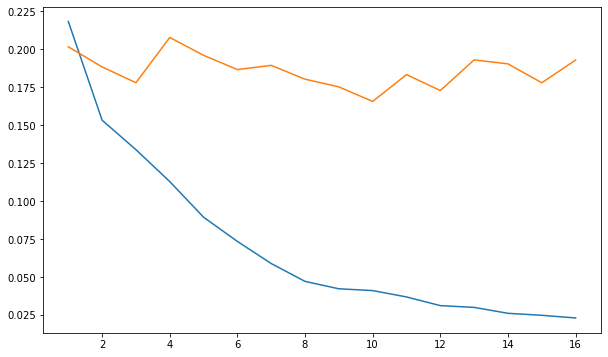

In [27]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter

# Custom Transform: Normalize 3D Tensor
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# Define transformations
train_transforms = Normalize3D()
val_test_transforms = Normalize3D()

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

def get_simple_model():
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=8, model_name='model'):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, f'{model_name}.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

def evaluate_ensemble(models, dataloader, device, thresholds):
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            ensemble_outputs = []

            for model in models:
                outputs = model(inputs).squeeze(dim=-1)
                probs = torch.sigmoid(outputs)
                ensemble_outputs.append(probs.cpu().numpy())

            # Average probabilities across models
            avg_probs = np.mean(ensemble_outputs, axis=0)

            all_probs.extend(avg_probs)
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Use average threshold
    avg_threshold = np.mean(thresholds)
    preds = (all_probs > avg_threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score for both classes
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def plot_history(histories):
    epochs = range(1, len(histories[0]['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(histories):
        plt.plot(epochs, history['train_loss'], label=f'Model {i+1} Train Loss')
        plt.plot(epochs, history['val_loss'], label=f'Model {i+1} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(histories):
        plt.plot(epochs, history['train_acc'], label=f'Model {i+1} Train Acc')
        plt.plot(epochs, history['val_acc'], label=f'Model {i+1} Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Datasets
    train_dataset = MRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_models = 3  # Number of models in the ensemble
    models = []
    histories = []
    thresholds = []

    for i in range(num_models):
        print(f"\nTraining Model {i+1}/{num_models}")
        model = get_simple_model().to(device)
        # Use Focal Loss with adjusted parameters
        criterion = FocalLoss(alpha=0.75, gamma=1.0)
        # Adjust optimizer and learning rate
        optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5)
        # Train the model
        model, history, best_threshold = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, model_name=f'model_{i+1}'
        )
        models.append(model)
        histories.append(history)
        thresholds.append(best_threshold)

    # Evaluate ensemble on test set
    test_labels, test_preds, test_probs = evaluate_ensemble(models, test_loader, device, thresholds)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(histories)

if __name__ == "__main__":
    main()


In [28]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter
from tqdm import tqdm  # For progress bars

# ----------------------------
# Custom Transform: Normalize 3D Tensor
# ----------------------------
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# ----------------------------
# Dataset Classes
# ----------------------------
class OversampledMRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats,
    with oversampling of the minority class.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        control_file_paths = [
            os.path.join(control_dir, filename)
            for filename in sorted(os.listdir(control_dir))
            if filename.endswith('.nii.gz')
        ]
        control_labels = [0] * len(control_file_paths)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        parkinson_file_paths = [
            os.path.join(parkinson_dir, filename)
            for filename in sorted(os.listdir(parkinson_dir))
            if filename.endswith('.nii.gz')
        ]
        parkinson_labels = [1] * len(parkinson_file_paths)  # Label for Parkinson's patients

        # Oversample minority class
        num_control = len(control_file_paths)
        num_parkinson = len(parkinson_file_paths)
        if num_control < num_parkinson:
            # Upsample controls
            upsample_factor = num_parkinson // num_control
            remainder = num_parkinson % num_control

            oversampled_control_file_paths = control_file_paths * upsample_factor + control_file_paths[:remainder]
            oversampled_control_labels = control_labels * upsample_factor + control_labels[:remainder]

            oversampled_parkinson_file_paths = parkinson_file_paths
            oversampled_parkinson_labels = parkinson_labels
        elif num_parkinson < num_control:
            # Upsample Parkinson's
            upsample_factor = num_control // num_parkinson
            remainder = num_control % num_parkinson

            oversampled_parkinson_file_paths = parkinson_file_paths * upsample_factor + parkinson_file_paths[:remainder]
            oversampled_parkinson_labels = parkinson_labels * upsample_factor + parkinson_labels[:remainder]

            oversampled_control_file_paths = control_file_paths
            oversampled_control_labels = control_labels
        else:
            # Classes are balanced
            oversampled_control_file_paths = control_file_paths
            oversampled_control_labels = control_labels
            oversampled_parkinson_file_paths = parkinson_file_paths
            oversampled_parkinson_labels = parkinson_labels

        # Combine the oversampled lists
        self.file_paths = oversampled_control_file_paths + oversampled_parkinson_file_paths
        self.labels = oversampled_control_labels + oversampled_parkinson_labels

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

# ----------------------------
# Utility Functions
# ----------------------------
def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

# ----------------------------
# Model Definitions
# ----------------------------
def get_simple_model(device):
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model.to(device)

def get_resnet18_model(device):
    # Initialize a 3D ResNet-18 model
    model = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)
    # Modify the first convolution layer to accept 1 channel instead of 3
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    # Freeze the stem layers if desired (optional)
    for param in model.stem.parameters():
        param.requires_grad = False
    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)
    )
    return model.to(device)

def get_res2plus1d_model(device):
    # Initialize a 3D Res2Plus1D-18 model
    model = models.video.r2plus1d_18(weights=models.video.R2Plus1D_18_Weights.KINETICS400_V1)
    # Modify the first convolution layer to accept 1 channel instead of 3
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
    # Freeze the stem layers if desired (optional)
    for param in model.stem.parameters():
        param.requires_grad = False
    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)
    )
    return model.to(device)

# ----------------------------
# Loss Function
# ----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# ----------------------------
# Training and Validation Functions
# ----------------------------
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)  # Remove the unnecessary singleton dimension
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)  # Remove singleton dimension
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=20, model_name='model'):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, f'{model_name}.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

# ----------------------------
# Ensemble Evaluation Function
# ----------------------------
def evaluate_ensemble(models, dataloader, device, thresholds):
    models = [model.eval() for model in models]
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating Ensemble"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            ensemble_outputs = []

            for model in models:
                outputs = model(inputs).squeeze(dim=-1)
                probs = torch.sigmoid(outputs)
                ensemble_outputs.append(probs.cpu().numpy())

            # Average probabilities across models
            avg_probs = np.mean(ensemble_outputs, axis=0)

            all_probs.extend(avg_probs)
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Use average of best thresholds
    avg_threshold = np.mean(thresholds)
    preds = (all_probs > avg_threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

# ----------------------------
# Evaluation Metrics
# ----------------------------
def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score, Accuracy
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

# ----------------------------
# Plotting Function
# ----------------------------
def plot_history(histories):
    num_models = len(histories)
    num_epochs = max(len(history['train_loss']) for history in histories)
    epochs = range(1, num_epochs + 1)

    # Plot loss
    plt.figure(figsize=(12, 6))
    for idx, history in enumerate(histories):
        plt.plot(epochs[:len(history['train_loss'])], history['train_loss'], label=f'Model {idx+1} Train Loss')
        plt.plot(epochs[:len(history['val_loss'])], history['val_loss'], label=f'Model {idx+1} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    for idx, history in enumerate(histories):
        plt.plot(epochs[:len(history['train_acc'])], history['train_acc'], label=f'Model {idx+1} Train Acc')
        plt.plot(epochs[:len(history['val_acc'])], history['val_acc'], label=f'Model {idx+1} Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# Main Function
# ----------------------------
def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Define transformations
    train_transforms = Normalize3D()
    val_test_transforms = Normalize3D()

    # Datasets
    train_dataset = OversampledMRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Initialize models
    simple_cnn = get_simple_model(device)
    resnet18 = get_resnet18_model(device)
    res2plus1d = get_res2plus1d_model(device)

    models_list = [
        ('simple_cnn', simple_cnn),
        ('resnet18', resnet18),
        ('res2plus1d', res2plus1d)
    ]

    # Training parameters
    num_epochs = 40
    patience = 20
    criterion = FocalLoss(alpha=0.75, gamma=1.0)

    trained_models = []
    histories = []
    thresholds = []

    for model_name, model in models_list:
        print(f"\n=== Training {model_name} ===")
        # Adjust optimizer and learning rate based on model
        if model_name == 'simple_cnn':
            optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5)
        else:
            optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Train the model
        model, history, best_threshold = train_model(
            model, train_loader, val_loader, criterion, optimizer, device,
            num_epochs=num_epochs, patience=patience, model_name=f'best_{model_name}'
        )

        trained_models.append(model)
        histories.append(history)
        thresholds.append(best_threshold)

    # Evaluate ensemble on test set
    print("\n=== Evaluating Ensemble on Test Set ===")
    test_labels, test_preds, test_probs = evaluate_ensemble(trained_models, test_loader, device, thresholds)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(histories)

if __name__ == "__main__":
    main()


Training samples: 1602
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 801, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}

Using device: cuda



Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /home/pfc5346/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|████████████████████████████████████████| 120M/120M [00:01<00:00, 79.2MB/s]
/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training simple_cnn ===
Epoch 1/40
----------


Train Loss: 0.2262 Acc: 0.6629


Val   Loss: 0.2041 Acc: 0.7546
✅ Best model saved!
Epoch 2/40
----------


Train Loss: 0.1925 Acc: 0.7434


Val   Loss: 0.2213 Acc: 0.7669
✅ Best model saved!
Epoch 3/40
----------


Train Loss: 0.1774 Acc: 0.7797


Val   Loss: 0.2002 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 4/40
----------


Train Loss: 0.1583 Acc: 0.8265


Val   Loss: 0.1853 Acc: 0.7730
✅ Best model saved!
Epoch 5/40
----------


Train Loss: 0.1431 Acc: 0.8471


Val   Loss: 0.1785 Acc: 0.7975
✅ Best model saved!
Epoch 6/40
----------


Train Loss: 0.1168 Acc: 0.8789


Val   Loss: 0.1841 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 7/40
----------


Train Loss: 0.0952 Acc: 0.9207


Val   Loss: 0.1621 Acc: 0.8160
✅ Best model saved!
Epoch 8/40
----------


Train Loss: 0.0698 Acc: 0.9482


Val   Loss: 0.1540 Acc: 0.8098
⏳ No improvement for 1 epochs.
Epoch 9/40
----------


Train Loss: 0.0595 Acc: 0.9600


Val   Loss: 0.1622 Acc: 0.8160
⏳ No improvement for 2 epochs.
Epoch 10/40
----------


Train Loss: 0.0499 Acc: 0.9675


Val   Loss: 0.1742 Acc: 0.8160
⏳ No improvement for 3 epochs.
Epoch 11/40
----------


Train Loss: 0.0388 Acc: 0.9794


Val   Loss: 0.1726 Acc: 0.8589
✅ Best model saved!
Epoch 12/40
----------


Train Loss: 0.0347 Acc: 0.9813


Val   Loss: 0.1647 Acc: 0.8466
⏳ No improvement for 1 epochs.
Epoch 13/40
----------


Train Loss: 0.0285 Acc: 0.9913


Val   Loss: 0.1919 Acc: 0.8221
⏳ No improvement for 2 epochs.
Epoch 14/40
----------


Train Loss: 0.0239 Acc: 0.9894


Val   Loss: 0.1972 Acc: 0.8160
⏳ No improvement for 3 epochs.
Epoch 15/40
----------


Train Loss: 0.0244 Acc: 0.9900


Val   Loss: 0.1803 Acc: 0.8528
⏳ No improvement for 4 epochs.
Epoch 16/40
----------


Train Loss: 0.0254 Acc: 0.9856


Val   Loss: 0.1813 Acc: 0.8589
⏳ No improvement for 5 epochs.
Epoch 17/40
----------


Train Loss: 0.0222 Acc: 0.9913


Val   Loss: 0.1948 Acc: 0.8221
⏳ No improvement for 6 epochs.
Epoch 18/40
----------


Train Loss: 0.0234 Acc: 0.9900


Val   Loss: 0.1846 Acc: 0.8466
⏳ No improvement for 7 epochs.
Epoch 19/40
----------


Train Loss: 0.0213 Acc: 0.9938


Val   Loss: 0.1947 Acc: 0.8221
⏳ No improvement for 8 epochs.
Epoch 20/40
----------


Train Loss: 0.0219 Acc: 0.9913


Val   Loss: 0.1865 Acc: 0.8466
⏳ No improvement for 9 epochs.
Epoch 21/40
----------


Train Loss: 0.0216 Acc: 0.9913


Val   Loss: 0.1850 Acc: 0.8466
⏳ No improvement for 10 epochs.
Epoch 22/40
----------


Train Loss: 0.0231 Acc: 0.9900


Val   Loss: 0.1895 Acc: 0.8466
⏳ No improvement for 11 epochs.
Epoch 23/40
----------


Train Loss: 0.0196 Acc: 0.9906


Val   Loss: 0.1941 Acc: 0.8344
⏳ No improvement for 12 epochs.
Epoch 24/40
----------


Train Loss: 0.0213 Acc: 0.9900


Val   Loss: 0.1933 Acc: 0.8528
⏳ No improvement for 13 epochs.
Epoch 25/40
----------


Train Loss: 0.0199 Acc: 0.9938


Val   Loss: 0.1922 Acc: 0.8466
⏳ No improvement for 14 epochs.
Epoch 26/40
----------


Train Loss: 0.0213 Acc: 0.9925


Val   Loss: 0.1888 Acc: 0.8589
⏳ No improvement for 15 epochs.
Epoch 27/40
----------


Train Loss: 0.0215 Acc: 0.9931


Val   Loss: 0.1905 Acc: 0.8466
⏳ No improvement for 16 epochs.
Epoch 28/40
----------


Train Loss: 0.0218 Acc: 0.9919


Val   Loss: 0.1894 Acc: 0.8528
⏳ No improvement for 17 epochs.
Epoch 29/40
----------


Train Loss: 0.0192 Acc: 0.9956


Val   Loss: 0.1914 Acc: 0.8528
⏳ No improvement for 18 epochs.
Epoch 30/40
----------


Train Loss: 0.0186 Acc: 0.9950


Val   Loss: 0.1923 Acc: 0.8528
⏳ No improvement for 19 epochs.
Epoch 31/40
----------


Train Loss: 0.0201 Acc: 0.9919


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Val   Loss: 0.1910 Acc: 0.8466
⏳ No improvement for 20 epochs.
🛑 Early stopping triggered.

=== Training resnet18 ===
Epoch 1/40
----------


Train Loss: 0.1083 Acc: 0.8858


Val   Loss: 0.2030 Acc: 0.7485
✅ Best model saved!
Epoch 2/40
----------


Train Loss: 0.0562 Acc: 0.9532


Val   Loss: 0.2577 Acc: 0.7055
⏳ No improvement for 1 epochs.
Epoch 3/40
----------


Train Loss: 0.0370 Acc: 0.9682


Val   Loss: 0.2757 Acc: 0.6871
⏳ No improvement for 2 epochs.
Epoch 4/40
----------


Train Loss: 0.0346 Acc: 0.9775


Val   Loss: 0.4870 Acc: 0.5890
⏳ No improvement for 3 epochs.
Epoch 5/40
----------


Train Loss: 0.0081 Acc: 0.9956


Val   Loss: 0.3610 Acc: 0.8160
✅ Best model saved!
Epoch 6/40
----------


Train Loss: 0.0117 Acc: 0.9938


Val   Loss: 0.3909 Acc: 0.7546
⏳ No improvement for 1 epochs.
Epoch 7/40
----------


Train Loss: 0.0108 Acc: 0.9906


Val   Loss: 0.2708 Acc: 0.7791
⏳ No improvement for 2 epochs.
Epoch 8/40
----------


Train Loss: 0.0091 Acc: 0.9950


Val   Loss: 0.2113 Acc: 0.7975
⏳ No improvement for 3 epochs.
Epoch 9/40
----------


Train Loss: 0.0075 Acc: 0.9963


Val   Loss: 0.2545 Acc: 0.8344
✅ Best model saved!
Epoch 10/40
----------


Train Loss: 0.0014 Acc: 1.0000


Val   Loss: 0.3059 Acc: 0.8282
⏳ No improvement for 1 epochs.
Epoch 11/40
----------


Train Loss: 0.0090 Acc: 0.9881


Val   Loss: 0.2910 Acc: 0.8528
✅ Best model saved!
Epoch 12/40
----------


Train Loss: 0.0023 Acc: 0.9988


Val   Loss: 0.3392 Acc: 0.8344
⏳ No improvement for 1 epochs.
Epoch 13/40
----------


Train Loss: 0.0024 Acc: 0.9975


Val   Loss: 0.3437 Acc: 0.8282
⏳ No improvement for 2 epochs.
Epoch 14/40
----------


Train Loss: 0.0029 Acc: 0.9975


Val   Loss: 0.2609 Acc: 0.8344
⏳ No improvement for 3 epochs.
Epoch 15/40
----------


Train Loss: 0.0039 Acc: 0.9950


Val   Loss: 0.2655 Acc: 0.8221
⏳ No improvement for 4 epochs.
Epoch 16/40
----------


Train Loss: 0.0011 Acc: 1.0000


Val   Loss: 0.3658 Acc: 0.8037
⏳ No improvement for 5 epochs.
Epoch 17/40
----------


Train Loss: 0.0013 Acc: 0.9994


Val   Loss: 0.3262 Acc: 0.8282
⏳ No improvement for 6 epochs.
Epoch 18/40
----------


Train Loss: 0.0014 Acc: 1.0000


Val   Loss: 0.4104 Acc: 0.7914
⏳ No improvement for 7 epochs.
Epoch 19/40
----------


Train Loss: 0.0024 Acc: 0.9975


Val   Loss: 0.2981 Acc: 0.8466
⏳ No improvement for 8 epochs.
Epoch 20/40
----------


Train Loss: 0.0021 Acc: 0.9981


Val   Loss: 0.3335 Acc: 0.8221
⏳ No improvement for 9 epochs.
Epoch 21/40
----------


Train Loss: 0.0027 Acc: 0.9975


Val   Loss: 0.3614 Acc: 0.8344
⏳ No improvement for 10 epochs.
Epoch 22/40
----------


Train Loss: 0.0020 Acc: 0.9981


Val   Loss: 0.3186 Acc: 0.8344
⏳ No improvement for 11 epochs.
Epoch 23/40
----------


Train Loss: 0.0015 Acc: 0.9994


Val   Loss: 0.4220 Acc: 0.7975
⏳ No improvement for 12 epochs.
Epoch 24/40
----------


Train Loss: 0.0049 Acc: 0.9944


Val   Loss: 0.2715 Acc: 0.8466
⏳ No improvement for 13 epochs.
Epoch 25/40
----------


Train Loss: 0.0018 Acc: 0.9988


Val   Loss: 0.3841 Acc: 0.8221
⏳ No improvement for 14 epochs.
Epoch 26/40
----------


Train Loss: 0.0020 Acc: 0.9988


Val   Loss: 0.4229 Acc: 0.8098
⏳ No improvement for 15 epochs.
Epoch 27/40
----------


Train Loss: 0.0015 Acc: 0.9994


Val   Loss: 0.3900 Acc: 0.8405
⏳ No improvement for 16 epochs.
Epoch 28/40
----------


Train Loss: 0.0017 Acc: 0.9988


Val   Loss: 0.3167 Acc: 0.8528
⏳ No improvement for 17 epochs.
Epoch 29/40
----------


Train Loss: 0.0039 Acc: 0.9963


Val   Loss: 0.4187 Acc: 0.8037
⏳ No improvement for 18 epochs.
Epoch 30/40
----------


Train Loss: 0.0022 Acc: 0.9988


Val   Loss: 0.3234 Acc: 0.8466
⏳ No improvement for 19 epochs.
Epoch 31/40
----------


Train Loss: 0.0021 Acc: 0.9988


Val   Loss: 0.3423 Acc: 0.8589
✅ Best model saved!
Epoch 32/40
----------


Train Loss: 0.0019 Acc: 0.9981


Val   Loss: 0.4327 Acc: 0.8098
⏳ No improvement for 1 epochs.
Epoch 33/40
----------


Train Loss: 0.0013 Acc: 1.0000


Val   Loss: 0.4118 Acc: 0.8160
⏳ No improvement for 2 epochs.
Epoch 34/40
----------


Train Loss: 0.0020 Acc: 0.9981


Val   Loss: 0.2920 Acc: 0.8466
⏳ No improvement for 3 epochs.
Epoch 35/40
----------


Train Loss: 0.0023 Acc: 0.9981


Val   Loss: 0.3397 Acc: 0.8466
⏳ No improvement for 4 epochs.
Epoch 36/40
----------


Train Loss: 0.0031 Acc: 0.9969


Val   Loss: 0.3039 Acc: 0.8466
⏳ No improvement for 5 epochs.
Epoch 37/40
----------


Train Loss: 0.0003 Acc: 1.0000


Val   Loss: 0.2877 Acc: 0.8405
⏳ No improvement for 6 epochs.
Epoch 38/40
----------


Train Loss: 0.0022 Acc: 0.9994


Val   Loss: 0.3362 Acc: 0.8466
⏳ No improvement for 7 epochs.
Epoch 39/40
----------


Train Loss: 0.0015 Acc: 0.9994


Val   Loss: 0.3870 Acc: 0.8282
⏳ No improvement for 8 epochs.
Epoch 40/40
----------


Train Loss: 0.0021 Acc: 0.9988


/home/pfc5346/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Val   Loss: 0.2779 Acc: 0.8405
⏳ No improvement for 9 epochs.

=== Training res2plus1d ===
Epoch 1/40
----------


RuntimeError: running_mean should contain 64 elements not 45

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from collections import Counter
from tqdm import tqdm  # For progress bars

# ----------------------------
# Custom Transform: Normalize 3D Tensor
# ----------------------------
class Normalize3D:
    """
    Normalizes a 3D tensor to have zero mean and unit variance.
    """
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std == 0:
            return tensor - mean
        return (tensor - mean) / (std + 1e-8)

# ----------------------------
# Dataset Classes
# ----------------------------
class OversampledMRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats,
    with oversampling of the minority class.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        control_file_paths = [
            os.path.join(control_dir, filename)
            for filename in sorted(os.listdir(control_dir))
            if filename.endswith('.nii.gz')
        ]
        control_labels = [0] * len(control_file_paths)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        parkinson_file_paths = [
            os.path.join(parkinson_dir, filename)
            for filename in sorted(os.listdir(parkinson_dir))
            if filename.endswith('.nii.gz')
        ]
        parkinson_labels = [1] * len(parkinson_file_paths)  # Label for Parkinson's patients

        # Oversample minority class
        num_control = len(control_file_paths)
        num_parkinson = len(parkinson_file_paths)
        if num_control < num_parkinson:
            # Upsample controls
            upsample_factor = num_parkinson // num_control
            remainder = num_parkinson % num_control

            oversampled_control_file_paths = control_file_paths * upsample_factor + control_file_paths[:remainder]
            oversampled_control_labels = control_labels * upsample_factor + control_labels[:remainder]

            oversampled_parkinson_file_paths = parkinson_file_paths
            oversampled_parkinson_labels = parkinson_labels
        elif num_parkinson < num_control:
            # Upsample Parkinson's
            upsample_factor = num_control // num_parkinson
            remainder = num_control % num_parkinson

            oversampled_parkinson_file_paths = parkinson_file_paths * upsample_factor + parkinson_file_paths[:remainder]
            oversampled_parkinson_labels = parkinson_labels * upsample_factor + parkinson_labels[:remainder]

            oversampled_control_file_paths = control_file_paths
            oversampled_control_labels = control_labels
        else:
            # Classes are balanced
            oversampled_control_file_paths = control_file_paths
            oversampled_control_labels = control_labels
            oversampled_parkinson_file_paths = parkinson_file_paths
            oversampled_parkinson_labels = parkinson_labels

        # Combine the oversampled lists
        self.file_paths = oversampled_control_file_paths + oversampled_parkinson_file_paths
        self.labels = oversampled_control_labels + oversampled_parkinson_labels

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images stored in .nii.gz formats.
    """
    def __init__(self, control_dir, parkinson_dir, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # List all control files and assign label 0
        for filename in sorted(os.listdir(control_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(control_dir, filename))
                self.labels.append(0)  # Label for healthy controls

        # List all Parkinson's files and assign label 1
        for filename in sorted(os.listdir(parkinson_dir)):
            if filename.endswith('.nii.gz'):
                self.file_paths.append(os.path.join(parkinson_dir, filename))
                self.labels.append(1)  # Label for Parkinson's patients

        # Shuffle the dataset
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths[:], self.labels[:] = zip(*combined)

        assert len(self.file_paths) == len(self.labels), "Mismatch between file paths and labels."

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load the image using SimpleITK
        try:
            image = sitk.ReadImage(img_path)
            image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        # Ensure the image has 3D dimensions and add a channel dimension
        image_array = np.expand_dims(image_array, axis=0)  # Shape: (1, D, H, W)

        # Convert to float32 tensor
        image_tensor = torch.from_numpy(image_array).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

# ----------------------------
# Utility Functions
# ----------------------------
def get_class_distribution(dataset):
    labels = np.array(dataset.labels)
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

# ----------------------------
# Model Definitions
# ----------------------------
def get_simple_model(device):
    # Define a simpler 3D CNN model
    model = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Conv3d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(),
        nn.MaxPool3d(2),
        nn.Flatten(),
        nn.Linear(32 * 28 * 28 * 4, 64),  # Adjust dimensions based on input size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
    )
    return model.to(device)

def get_resnet18_model(device):
    # Initialize a 3D ResNet-18 model
    model = models.video.r3d_18(weights=models.video.R3D_18_Weights.DEFAULT)
    # Modify the first convolution layer to accept 1 channel instead of 3
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    # Freeze the stem layers if desired (optional)
    for param in model.stem.parameters():
        param.requires_grad = False
    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)
    )
    return model.to(device)

def get_res2plus1d_model(device):
    # Initialize a 3D Res2Plus1D-18 model
    model = models.video.r2plus1d_18(weights=models.video.R2Plus1D_18_Weights.DEFAULT)
    # Modify the first convolution layer to accept 1 channel instead of 3
    model.stem[0] = nn.Conv3d(1, 45, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
    # Adjust the BatchNorm layer's num_features
    model.stem[1] = nn.BatchNorm3d(45)
    # Freeze the stem layers if desired (optional)
    for param in model.stem.parameters():
        param.requires_grad = False
    # Modify the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)
    )
    return model.to(device)

# ----------------------------
# Loss Function
# ----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        targets = targets.float()
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# ----------------------------
# Training and Validation Functions
# ----------------------------
def resize_depth(tensor, target_depth):
    _, _, depth, height, width = tensor.shape
    if depth != target_depth:
        tensor = nn.functional.interpolate(tensor, size=(target_depth, height, width), mode='trilinear', align_corners=False)
    return tensor

def train_one_epoch(model, train_loader, criterion, optimizer, device, target_depth=None):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        if target_depth is not None:
            inputs = resize_depth(inputs, target_depth)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=-1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device, target_depth=None):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            if target_depth is not None:
                inputs = resize_depth(inputs, target_depth)

            # Forward pass
            outputs = model(inputs).squeeze(dim=-1)
            loss = criterion(outputs, labels)

            # Collect outputs and labels for threshold optimization
            all_outputs.append(outputs)
            all_labels.append(labels)

            # Statistics
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Find optimal threshold
    best_threshold = find_optimal_threshold(all_outputs, all_labels)

    return avg_loss, accuracy, best_threshold

def find_optimal_threshold(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().numpy()
    labels = labels.cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40, patience=20, model_name='model', target_depth=None):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.5)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, target_depth)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, best_threshold = validate_one_epoch(model, val_loader, criterion, device, target_depth)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, f'{model_name}.pth')
            print("✅ Best model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history, best_threshold

# ----------------------------
# Ensemble Evaluation Function
# ----------------------------
def evaluate_ensemble(models, dataloader, device, thresholds, target_depths):
    models = [model.eval() for model in models]
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating Ensemble"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            ensemble_outputs = []

            for model, target_depth in zip(models, target_depths):
                model_inputs = inputs
                if target_depth is not None:
                    model_inputs = resize_depth(model_inputs, target_depth)
                outputs = model(model_inputs).squeeze(dim=-1)
                probs = torch.sigmoid(outputs)
                ensemble_outputs.append(probs.cpu().numpy())

            # Average probabilities across models
            avg_probs = np.mean(ensemble_outputs, axis=0)

            all_probs.extend(avg_probs)
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Use average of best thresholds
    avg_threshold = np.mean(thresholds)
    preds = (all_probs > avg_threshold).astype(int)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC-ROC: {auc:.4f}")

    return all_labels, preds, all_probs

# ----------------------------
# Evaluation Metrics
# ----------------------------
def print_metrics(labels, preds):
    # Classification Report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Healthy", "Parkinson's"]))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Precision, Recall, F1 Score, Accuracy
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    accuracy = accuracy_score(labels, preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Specificity (True Negative Rate)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero
    print(f"Specificity: {specificity:.4f}")

# ----------------------------
# Plotting Function
# ----------------------------
def plot_history(histories):
    num_models = len(histories)
    num_epochs = max(len(history['train_loss']) for history in histories)
    epochs = range(1, num_epochs + 1)

    # Plot loss
    plt.figure(figsize=(12, 6))
    for idx, history in enumerate(histories):
        plt.plot(epochs[:len(history['train_loss'])], history['train_loss'], label=f'Model {idx+1} Train Loss')
        plt.plot(epochs[:len(history['val_loss'])], history['val_loss'], label=f'Model {idx+1} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    for idx, history in enumerate(histories):
        plt.plot(epochs[:len(history['train_acc'])], history['train_acc'], label=f'Model {idx+1} Train Acc')
        plt.plot(epochs[:len(history['val_acc'])], history['val_acc'], label=f'Model {idx+1} Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# Main Function
# ----------------------------
def main():
    split_base_dir = "/home/pfc5346/Desktop/Project_finalWork/Dataset/res_split"

    # Paths for datasets
    train_control_dir = os.path.join(split_base_dir, "train", "control_augmented1")
    train_parkinson_dir = os.path.join(split_base_dir, "train", "parkinson")

    val_control_dir = os.path.join(split_base_dir, "val", "control")
    val_parkinson_dir = os.path.join(split_base_dir, "val", "parkinson")

    test_control_dir = os.path.join(split_base_dir, "test", "control")
    test_parkinson_dir = os.path.join(split_base_dir, "test", "parkinson")

    # Define transformations
    train_transforms = Normalize3D()
    val_test_transforms = Normalize3D()

    # Datasets
    train_dataset = OversampledMRIDataset(train_control_dir, train_parkinson_dir, transform=train_transforms)
    val_dataset = MRIDataset(val_control_dir, val_parkinson_dir, transform=val_test_transforms)
    test_dataset = MRIDataset(test_control_dir, test_parkinson_dir, transform=val_test_transforms)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Print class distributions
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    print(f"Training Class Distribution: {train_dist}")
    print(f"Validation Class Distribution: {val_dist}")
    print(f"Test Class Distribution: {test_dist}\n")

    batch_size = 8

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Initialize models
    simple_cnn = get_simple_model(device)
    resnet18 = get_resnet18_model(device)
    res2plus1d = get_res2plus1d_model(device)

    models_list = [
        ('simple_cnn', simple_cnn, None),  # target_depth=None for simple_cnn
        ('resnet18', resnet18, None),      # target_depth=None for resnet18
        ('res2plus1d', res2plus1d, 16)     # target_depth=16 for res2plus1d
    ]

    # Training parameters
    num_epochs = 40
    patience = 20
    criterion = FocalLoss(alpha=0.75, gamma=1.0)

    trained_models = []
    histories = []
    thresholds = []
    target_depths = []

    for model_name, model, target_depth in models_list:
        print(f"\n=== Training {model_name} ===")
        # Adjust optimizer and learning rate based on model
        if model_name == 'simple_cnn':
            optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5)
        else:
            optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Train the model
        model, history, best_threshold = train_model(
            model, train_loader, val_loader, criterion, optimizer, device,
            num_epochs=num_epochs, patience=patience, model_name=f'best_{model_name}', target_depth=target_depth
        )

        trained_models.append(model)
        histories.append(history)
        thresholds.append(best_threshold)
        target_depths.append(target_depth)

    # Evaluate ensemble on test set
    print("\n=== Evaluating Ensemble on Test Set ===")
    test_labels, test_preds, test_probs = evaluate_ensemble(trained_models, test_loader, device, thresholds, target_depths)
    print_metrics(test_labels, test_preds)

    # Plotting training/validation loss and accuracy
    plot_history(histories)

if __name__ == "__main__":
    main()


Training samples: 1602
Validation samples: 163
Test samples: 294

Training Class Distribution: {0: 801, 1: 801}
Validation Class Distribution: {0: 40, 1: 123}
Test Class Distribution: {0: 60, 1: 234}

Using device: cuda


=== Training simple_cnn ===
Epoch 1/40
----------


Training:  15%|████▊                           | 30/201 [00:05<00:29,  5.89it/s]